# Interfaces and workflows

Interfaces are the building blocks that solve well-defined tasks. We solve more complex tasks by combining interfaces with workflows:

| Interfaces                                                                                                                                                                                                                                                                                    | Workflows                                                                                                                                                                                                                                                                                                                                             |
|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| <ul> <li>Wrap *unitary* tasks</li> <li>Keep track of the inputs and outputs, and check their expected types</li> <li>Do not cache results (unless you use [interface caching](http://nipype.readthedocs.io/en/latest/users/caching_tutorial.html))</li> <li>Run by a nipype plugin</li> </ul> | <ul> <li>Wrap *meta*-tasks:  <ul> <li>implemented with nipype interfaces wrapped inside ``Node`` objects</li> <li>subworkflows can also be added to a workflow without any wrapping</li> </ul>  <li>Do not have inputs/outputs, but expose them from the interfaces wrapped inside</li> <li>Cache results</li>  <li>Run by a nipype plugin</li> </ul> |

For this notebook, we'll work on the following T1-weighted dataset located in ``/data/ds102/sub-01/anat/sub-01_T1w.nii.gz``:

Populating the interactive namespace from numpy and matplotlib


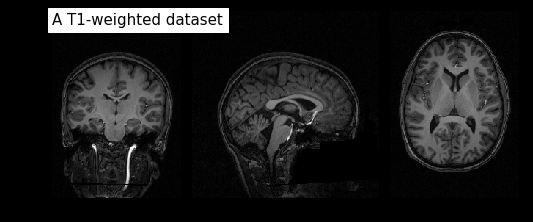

In [9]:
%pylab inline
from nilearn.plotting import plot_anat
plot_anat('/data/ds102/sub-01/anat/sub-01_T1w.nii.gz', title='A T1-weighted dataset',
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False)

## Example of interface: FSL's BET

Nipype offers a series of Python interfaces to various external packages (e.g. FSL, SPM or FreeSurfer) even if they themselves are written in programming languages other than python. Such interfaces know what sort of options their corresponding tool has and how to execute it.

To illustrate why interfaces are so useful, let's have a look at the brain extraction algorithm [BET](http://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET) from FSL. Once in its original framework and once in the Nipype framework.

The tool can be run directly in a bash shell using the following command line:

In [11]:
%%bash
bet /data/ds102/sub-01/anat/sub-01_T1w.nii.gz /data/ds102/sub-01/anat/sub-01_T1w_bet.nii.gz

... which yields the following:

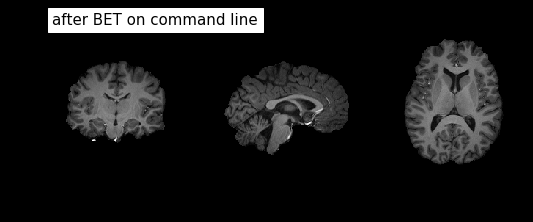

In [12]:
plot_anat('/data/ds102/sub-01/anat/sub-01_T1w_bet.nii.gz', title='after BET on command line',
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False)

Using nipype, the equivalent is a bit more verbose:
  - The first line imports the interface
  - Then, the interface is instantiated. We provide here the input file.
  - Finally, we run the interface
  - The output file name can be automatically handled by nipype, and we will use that feature here

In [17]:
from nipype.interfaces.fsl import BET
skullstrip = BET(in_file = "/data/ds102/sub-01/anat/sub-01_T1w.nii.gz")
res = skullstrip.run()

And we can check how the result is exactly the same as before. Please note that, since we are using a Python environment, we use the result of the execution to point our ``plot_anat`` function to the output image of running BET:

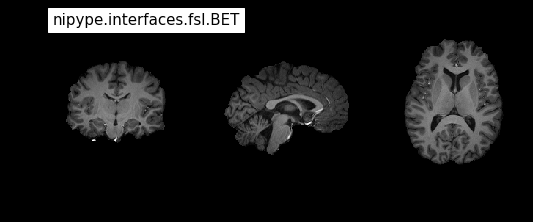

In [19]:
plot_anat(res.outputs.out_file, title='nipype.interfaces.fsl.BET',
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False)

## But wait! My tool is not (yet) supported by Nipype

Nipype is designed to ease writing interfaces for new software. Nipype interfaces are designed with three elements that are intuitive:
  - A specification of inputs (or the ``InputSpec``)
  - A specification of outputs (or the ``OutputSpec``)
  - An interface *core* which implements the ``run()`` method we've seen before for BET, and which puts together inputs and outputs.
  
### The ``CommandLine`` interface

The easiest / quickest way to run any command line is the ``CommandLine`` interface, which has a very simple specification of inputs ready to use:

In [20]:
from nipype.interfaces.base import CommandLine
CommandLine.help()

Wraps command **None**

Implements functionality to interact with command line programs
class must be instantiated with a command argument

Parameters
----------

command : string
    define base immutable `command` you wish to run

args : string, optional
    optional arguments passed to base `command`


Examples
--------
>>> import pprint
>>> from nipype.interfaces.base import CommandLine
>>> cli = CommandLine(command='ls', environ={'DISPLAY': ':1'})
>>> cli.inputs.args = '-al'
>>> cli.cmdline # doctest: +ALLOW_UNICODE
'ls -al'

>>> pprint.pprint(cli.inputs.trait_get())  # doctest: +NORMALIZE_WHITESPACE +ALLOW_UNICODE
{'args': '-al',
 'environ': {'DISPLAY': ':1'},
 'ignore_exception': False,
 'terminal_output': 'stream'}

>>> cli.inputs.get_hashval()[0][0] # doctest: +ALLOW_UNICODE
('args', '-al')
>>> cli.inputs.get_hashval()[1] # doctest: +ALLOW_UNICODE
'11c37f97649cd61627f4afe5136af8c0'

Inputs::

	[Mandatory]

	[Optional]
	args: (a unicode string)
		Additional parameters to the co

As a quick example, let's wrap the bash's ``ls`` with Nipype:

In [25]:
nipype_ls = CommandLine('ls', args='-lh', terminal_output='file')

Now, we have a Python object ``nipype_ls`` that is a runnable nipype interface. After execution, Nipype interface return a result object. We can retrieve the output of our ``ls`` invocation from the ``result.runtime`` property:

In [26]:
result = nipype_ls.run()
print(result.runtime.stdout)

total 3.7M
-rw-rw-rw- 1   1021  1001 279K Mar 24 18:43 basic_interfaces.ipynb
-rw-rw-r-- 1   1021  1001 797K Mar 24 17:56 basic_workflow.ipynb
-rw-r--r-- 1 jovyan users 252K Mar 24 18:55 interfaces_and_workflows.ipynb
-rw-r--r-- 1 jovyan users    0 Mar 24 18:55 stderr.nipype
-rw-r--r-- 1 jovyan users    0 Mar 24 18:55 stdout.nipype
-rw-r--r-- 1 jovyan users 2.4M Mar 24 18:39 sub-01_T1w_brain.nii.gz
drwxr-xr-x 4 jovyan users 4.0K Mar 23 23:12 working_dir


## My first implementation of a Nipype Interface to an external tool

Let's create a Nipype Interface for a very simple tool called ``antsTransformInfo`` from the [ANTs](http://stnava.github.io/ANTs/) package. This tool is so simple it does not even have an usage description for bash. So let's plan our implementation:

  1. The command line name is ``antsTransformInfo``
  2. It only accepts one text file (containing an ITK transform file) as input, and it is a positional argument
  3. Then, it prints out the properties of the transform in the input file. For the purpose of this guide, we are only interested on extracting the translation values.
  
For the first item of this roadmap, we will just need to derive a new Python class from the ``nipype.interfaces.base.CommandLine`` base. To indicate the appropriate command line, we set the member ``_cmd``:

In [30]:
class TransformInfo(CommandLine):
    _cmd = 'antsTransformInfo'

This is enough to have a nipype compatible interface for this tool:

In [32]:
TransformInfo.help()

Wraps command **antsTransformInfo**


Inputs::

	[Mandatory]

	[Optional]
	args: (a unicode string)
		Additional parameters to the command
		flag: %s
	environ: (a dictionary with keys which are a newbytes or None or a
		 newstr or None and with values which are a newbytes or None or a
		 newstr or None, nipype default value: {})
		Environment variables
	ignore_exception: (a boolean, nipype default value: False)
		Print an error message instead of throwing an exception in case the
		interface fails to run
	terminal_output: (u'stream' or u'allatonce' or u'file' or u'none')
		Control terminal output: `stream` - displays to terminal immediately
		(default), `allatonce` - waits till command is finished to display
		output, `file` - writes output to file, `none` - output is ignored

Outputs::

	None




#### Specifying the inputs

However, the ``args`` argument is too generic and does not deviate much from just running it in bash, or directly using ``subprocess.Popen``. Let's define the intputs specification for the interface, extending the ``nipype.interfaces.base.CommandLineInputSpec`` class.

The inputs are implemented using the Enthought traits package. For now, we'll use the ``File`` trait extension of nipype:

In [39]:
from nipype.interfaces.base import CommandLineInputSpec, File

class TransformInfoInputSpec(CommandLineInputSpec):
    in_file = File(exists=True, mandatory=True, argstr='%s', position=0, desc='the input transform file')

Some settings are done for this ``File`` object: the ``exists=True`` bit indicates Nipype that the file must exist when it is set. The ``mandatory=True`` checks that this input was set before running because the program would crash otherwise. The ``argstr='%s'`` indicates how this input parameter should be formatted. Finally, ``position=0`` indicates that this is the first positional argument.

We can now decorate our ``TransformInfo`` core class with its input, by setting the ``input_spec`` member:

In [40]:
class TransformInfo(CommandLine):
    _cmd = 'antsTransformInfo'
    input_spec = TransformInfoInputSpec

Our interface now has one mandatory input, and inherits some optional inputs from the ``CommandLineInputSpec``:

In [41]:
TransformInfo.help()

Wraps command **antsTransformInfo**


Inputs::

	[Mandatory]
	in_file: (an existing file name)
		the input transform file
		flag: %s, position: 0

	[Optional]
	args: (a unicode string)
		Additional parameters to the command
		flag: %s
	environ: (a dictionary with keys which are a newbytes or None or a
		 newstr or None and with values which are a newbytes or None or a
		 newstr or None, nipype default value: {})
		Environment variables
	ignore_exception: (a boolean, nipype default value: False)
		Print an error message instead of throwing an exception in case the
		interface fails to run
	terminal_output: (u'stream' or u'allatonce' or u'file' or u'none')
		Control terminal output: `stream` - displays to terminal immediately
		(default), `allatonce` - waits till command is finished to display
		output, `file` - writes output to file, `none` - output is ignored

Outputs::

	None




One interesting feature of the Nipype interface is that the underlying command line can be checked using the object property ``cmdline``. The command line can only be built when the mandatory inputs are set, so let's instantiate our new Interface for first time, and check the underlying command line:

In [48]:
my_info_interface = TransformInfo(in_file='files/transform.tfm')
print(my_info_interface.cmdline)

antsTransformInfo files/transform.tfm


Nipype will make sure that the parameters fullfil their prescribed attributes. For instance ``in_file`` is mandatory. An error is issued if we build the command line or try to run this interface without it:

In [49]:
TransformInfo().cmdline

ValueError: TransformInfo requires a value for input 'in_file'. For a list of required inputs, see TransformInfo.help()

It will also complain if we try to set a non-existent file:

In [50]:
my_info_interface.inputs.in_file = 'idontexist.tfm'

TraitError: The 'in_file' trait of a TransformInfoInputSpec instance must be an existing file name, but a value of 'idontexist.tfm' <type 'str'> was specified.

#### Specifying the outputs
The outputs are defined in a similar way. Let's define a custom output for our interface which is a list of three float element. The output traits are derived from a simpler base class called ``TraitedSpec``. We also import the two data representations we need ``List`` and ``Float``:

In [43]:
from nipype.interfaces.base import TraitedSpec, traits

class TransformInfoOutputSpec(TraitedSpec):
    translation = traits.List(traits.Float, desc='the translation component of the input transform')
    
class TransformInfo(CommandLine):
    _cmd = 'antsTransformInfo'
    input_spec = TransformInfoInputSpec
    output_spec = TransformInfoOutputSpec

And now, the our new output is in place:

In [45]:
TransformInfo.help()

Wraps command **antsTransformInfo**


Inputs::

	[Mandatory]
	in_file: (an existing file name)
		the input transform file
		flag: %s, position: 0

	[Optional]
	args: (a unicode string)
		Additional parameters to the command
		flag: %s
	environ: (a dictionary with keys which are a newbytes or None or a
		 newstr or None and with values which are a newbytes or None or a
		 newstr or None, nipype default value: {})
		Environment variables
	ignore_exception: (a boolean, nipype default value: False)
		Print an error message instead of throwing an exception in case the
		interface fails to run
	terminal_output: (u'stream' or u'allatonce' or u'file' or u'none')
		Control terminal output: `stream` - displays to terminal immediately
		(default), `allatonce` - waits till command is finished to display
		output, `file` - writes output to file, `none` - output is ignored

Outputs::

	translation: (a list of items which are a float)
		the translation component of the input transform




#### We are almost there: final needs
If we run the interface, we'll be able to see that this tool only writes some text to the standard output, but we just want to extract the ``Translation`` field and generate a Python object from it.

In [65]:
my_info_interface = TransformInfo(in_file='files/transform.tfm', terminal_output='file')
result = my_info_interface.run()

print(result.runtime.stdout)

Transform file: files/transform.tfm
AffineTransform (0x2cb0460)
RTTI typeinfo:   itk::AffineTransform<double, 3u>
Reference Count: 3
Modified Time: 660
Debug: Off
Object Name:
Observers:
none
Matrix:
1.0201 -0.00984231 0.00283729
-0.245557 0.916396 0.324585
-0.0198016 -0.00296066 0.988634
Offset: [2.00569, -15.15, -1.26341]
Center: [-3.37801, 17.4338, 8.46811]
Translation: [1.79024, -13.0295, -1.34439]
Inverse:
0.982713 0.0105343 -0.00627888
0.256084 1.09282 -0.359526
0.0204499 0.00348366 1.01029
Singular: 0



We need to complete the functionallity of the ``run()`` member of our interface to parse the standard output. This is done extending its ``_run_interface()`` member.

When we define outputs, generally they need to be explicitly wired in the ``_list_outputs()`` member of the core class. Let's see how we can *complete* those:

In [59]:
class TransformInfo(CommandLine):
    _cmd = 'antsTransformInfo'
    input_spec = TransformInfoInputSpec
    output_spec = TransformInfoOutputSpec
            
    def _run_interface(self, runtime):
        import re
        
        # Run the command line as a natural CommandLine interface
        runtime = super(TransformInfo, self)._run_interface(runtime)

        # Search transform in the standard output
        expr_tra = re.compile('Translation:\s+\[(?P<translation>[0-9\.-]+,\s[0-9\.-]+,\s[0-9\.-]+)\]')
        trans = [float(v) for v in expr_tra.search(runtime.stdout).group('translation').split(', ')]
        
        # Save it for later use in _list_outputs
        setattr(self, '_result', trans)
        
        # Good to go
        return runtime
    
    def _list_outputs(self):
        # Get the attribute saved during _run_interface
        return {'translation': getattr(self, '_result')}


Let's run this interface (we set ``terminal_output='file'`` to reduce the length of this manual):

In [63]:
my_info_interface = TransformInfo(in_file='files/transform.tfm', terminal_output='file')
result = my_info_interface.run()

Now we can retrieve our outcome of interest as an output:

In [64]:
result.outputs.translation

[1.79024, -13.0295, -1.34439]

#### Putting all together

In [66]:
from nipype.interfaces.base import CommandLineInputSpec, File, TraitedSpec, traits

class TransformInfoInputSpec(CommandLineInputSpec):
    in_file = File(exists=True, mandatory=True, argstr='%s', position=0, desc='the input transform file')
    
class TransformInfoOutputSpec(TraitedSpec):
    translation = traits.List(traits.Float, desc='the translation component of the input transform')

class TransformInfo(CommandLine):
    _cmd = 'antsTransformInfo'
    input_spec = TransformInfoInputSpec
    output_spec = TransformInfoOutputSpec
            
    def _run_interface(self, runtime):
        import re
        
        # Run the command line as a natural CommandLine interface
        runtime = super(TransformInfo, self)._run_interface(runtime)

        # Search transform in the standard output
        expr_tra = re.compile('Translation:\s+\[(?P<translation>[0-9\.-]+,\s[0-9\.-]+,\s[0-9\.-]+)\]')
        trans = [float(v) for v in expr_tra.search(runtime.stdout).group('translation').split(', ')]
        
        # Save it for later use in _list_outputs
        setattr(self, '_result', trans)
        
        # Good to go
        return runtime
    
    def _list_outputs(self):
        # Get the attribute saved during _run_interface
        return {'translation': getattr(self, '_result')}

#### Wrapping up
For more standard neuroimaging software, generally we will have input and output images. If that is the case, then there is no need to extend the ``run()`` method. Let's look at a quick, partial, implementation of FSL's BET:

In [67]:
from nipype.interfaces.base import CommandLineInputSpec, File, TraitedSpec

class CustomBETInputSpec(CommandLineInputSpec):
    in_file = File(exists=True, mandatory=True, argstr='%s', position=0, desc='the input image')
    out_file = File(exists=True, mandatory=True, argstr='%s', position=1, desc='the output image')
    
class CustomBETOutputSpec(TraitedSpec):
    out_file = File(desc='the output image')
    
class CustomBET(CommandLine):
    _cmd = 'bet'
    input_spec = CustomBETInputSpec
    output_spec = CustomBETOutputSpec
    
    def _list_outputs(self):
        # Get the attribute saved during _run_interface
        return {'out_file': self.inputs.out_file}

In [69]:
my_custom_bet = CustomBET()
my_custom_bet.inputs.in_file = '/data/ds102/sub-01/anat/sub-01_T1w.nii.gz'
my_custom_bet.inputs.out_file = 'sub-01_T1w_brain.nii.gz'
result = my_custom_bet.run()

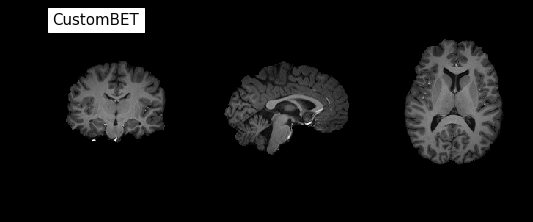

In [70]:
plot_anat(result.outputs.out_file, title='CustomBET',
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False)

## Great, but my tool is already Python - can 